In [2]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [4]:
# get the data
data= pd.read_csv('Real estate.csv')

In [26]:
# EDA
data.head()

,House age,Distance to the nearest MRT station,Number of convenience stores,House price
0,32.0,84.87882,10,37.9
1,19.5,306.59470,9,42.2
2,13.3,561.98450,5,47.3
3,13.3,561.98450,5,54.8
4,5.0,390.56840,5,43.1


In [28]:
data.shape

(414, 4)

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 4 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   House age                            414 non-null    float64
 1   Distance to the nearest MRT station  414 non-null    float64
 2   Number of convenience stores         414 non-null    int64  
 3   House price                          414 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 13.1 KB


In [32]:
data.isna().sum()

House age                              0
Distance to the nearest MRT station    0
Number of convenience stores           0
House price                            0
dtype: int64

In [14]:
# drop cols -> No, X1 transaction date, X5 latitude, X6 longitude
data.drop(columns=['No', 'X1 transaction date', 'X5 latitude', 'X6 longitude'], inplace=True)

In [24]:
# renaming the columns
data.rename(columns = {'X2 house age':'House age',
                        'X3 distance to the nearest MRT station': 'Distance to the nearest MRT station', 
                        'X4 number of convenience stores': 'Number of convenience stores',
                        'Y house price of unit area': 'House price'}, inplace = True)

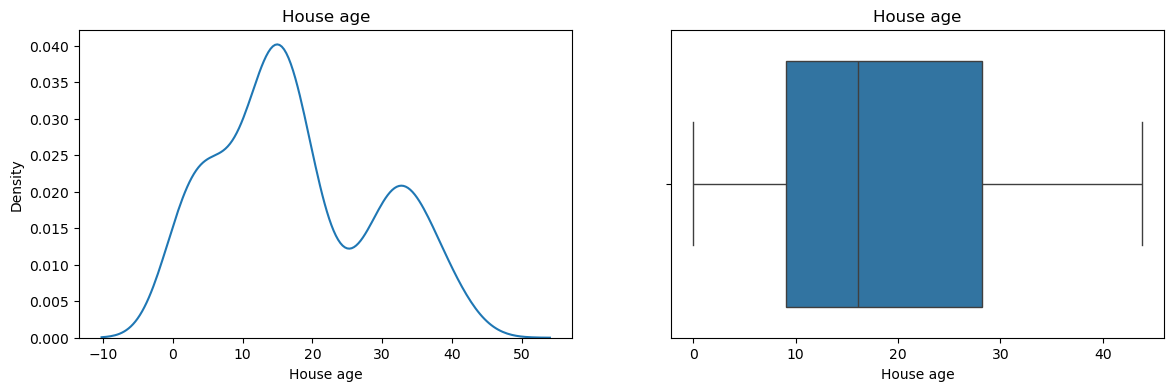

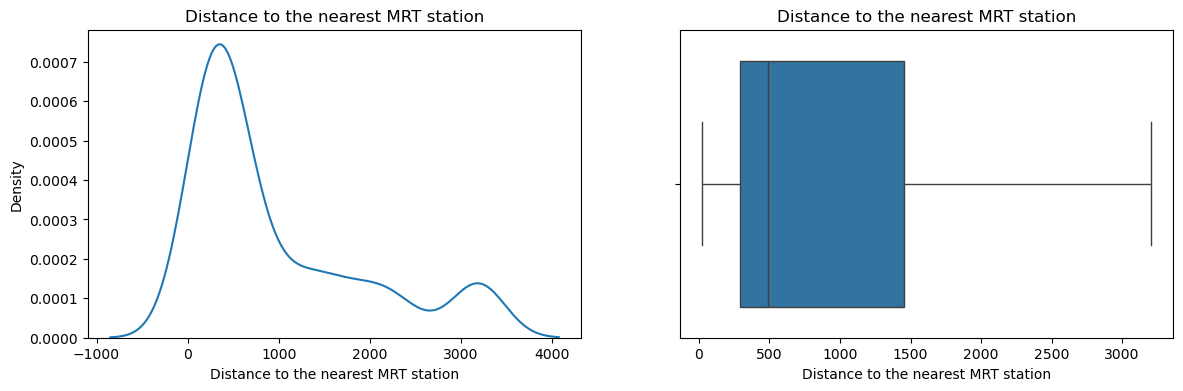

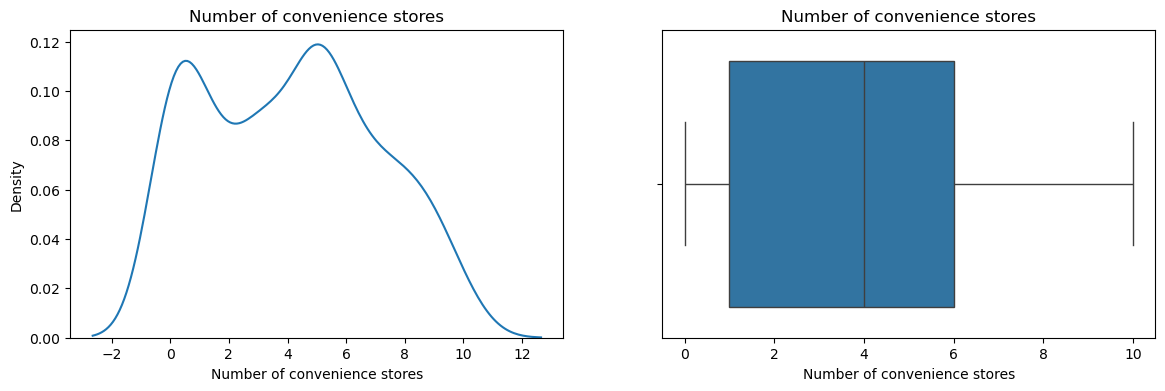

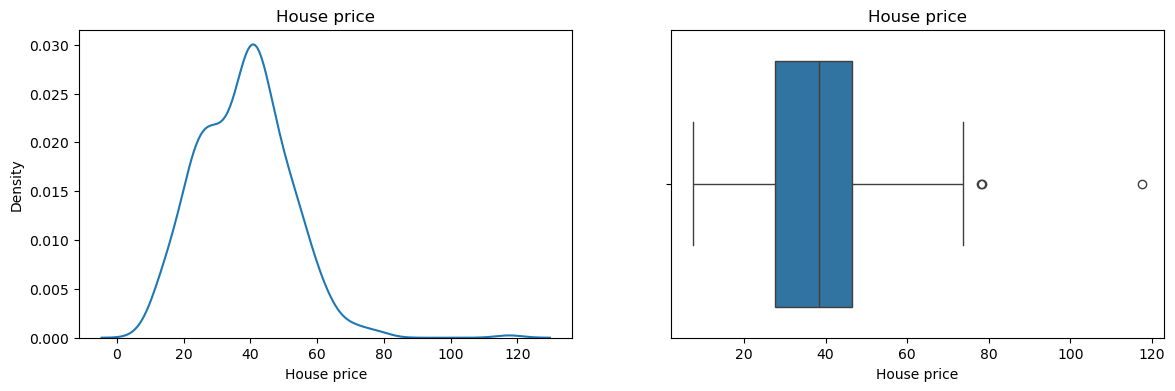

In [44]:
# see the data distributions of numeric columns
for col in data.columns:
    if data[col].dtype == 'object':
        continue

    plt.figure(figsize=(14,4))
    plt.subplot(121)
    sns.kdeplot(data=data, x = col)
    plt.title(col)
    
    plt.subplot(122)
    sns.boxplot(data=data, x = col, orient= 'h')
    plt.title(col)
    
    plt.show()


In [36]:
# outlier handling -> Distance to the nearest MRT station (IQR based as skewed)
q1, q3= np.percentile(data['Distance to the nearest MRT station'], [25, 75])
iqr= q3 - q1
upp_lim= q3 + 1.5*(iqr)
low_lim= q1 - 1.5*(iqr)

In [46]:
data['Distance to the nearest MRT station'].describe()

count     414.000000
mean      974.545851
std       968.915855
min        23.382840
25%       289.324800
50%       492.231300
75%      1454.279000
max      3201.710300
Name: Distance to the nearest MRT station, dtype: float64

In [40]:
upp_lim, low_lim

(3201.7103, -1458.1065000000003)

In [42]:
data['Distance to the nearest MRT station']= np.where(
    data['Distance to the nearest MRT station'] > upp_lim,
    upp_lim,
    np.where(
        data['Distance to the nearest MRT station'] < low_lim,
        low_lim,
        data['Distance to the nearest MRT station']
    )
)

In [48]:
# features and labels
X= data.drop('House price', axis=1)
Y= data['House price']

In [50]:
# train test split
X_train, X_test, y_train, y_test= train_test_split(X, Y, test_size=0.2)

In [54]:
# power transformer
numeric_transformer= Pipeline([
    ('power_transformer', PowerTransformer())
])

In [58]:
# preprocessor
preprocessor= ColumnTransformer([
    ('numeric_transformer', numeric_transformer, X.columns)
], remainder= 'passthrough')

In [60]:
# model
model= LinearRegression()

In [62]:
# pipeline
pipe= Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

In [64]:
# fit
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric_transformer',
                                                  Pipeline(steps=[('power_transformer',
                                                                   PowerTransformer())]),
                                                  Index(['House age', 'Distance to the nearest MRT station',
       'Number of convenience stores'],
      dtype='object'))])),
                ('model', LinearRegression())])

In [66]:
# predict
y_preds= pipe.predict(X_test)

In [68]:
# evaluate

In [70]:
mean_absolute_error(y_test, y_preds)

5.49624704121167

In [72]:
mean_squared_error(y_test, y_preds)

61.49853563717378

In [76]:
np.sqrt(mean_squared_error(y_test, y_preds))

7.842100205759538

In [78]:
r2_score(y_test, y_preds)

0.6574350841603643

In [82]:
n = X_test.shape[0]  # Number of observations

p = X_test.shape[1]  # Number of predictors (features)

r2= r2_score(y_test, y_preds)

adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"Adjusted R-squared: {adjusted_r2}")

Adjusted R-squared: 0.6444262898879731


In [86]:
# find the best params for PCA

max_r2= 0
best_comps= 0

for i in range(1, 4):
    pipe= Pipeline([
        ('preprocessor', preprocessor),
        ('PCA', PCA(n_components=i)),
        ('model', model)
    ])

    pipe.fit(X_train, y_train)
    y_preds= pipe.predict(X_test)
    r2_sc= r2_score(y_test, y_preds)
    
    if r2_sc > max_r2:
        max_r2= r2_sc
        best_comps= i

    print(f"{i} comps := {r2_sc}")

print(f"\n\nBest comps: {best_comps}, R2: {max_r2}")

1 comps := 0.6161922745059516
2 comps := 0.6422261483939702
3 comps := 0.6574350841603643


Best comps: 3, R2: 0.6574350841603643
